In [47]:
import pandas as pd
from provisioning_model.functions.exploratory_analysis import create_scatter_plots_grid

In [48]:
time_periods = ['2008', '2012', '2016', '2020']
foundational_df_no_transformations = pd.read_csv('./output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('./output/foundational_transformed.csv')

Values from the StandardScaler used to transform the data

In [53]:
scaler_df = pd.read_csv('./output/scaler_values.csv')
energy_scale = scaler_df.loc[scaler_df['variable'] == 'energy', 'scale'].values[0]
energy_mean = scaler_df.loc[scaler_df['variable'] == 'energy', 'mean'].values[0]

## Hypothesis

The higher the share of employment/labor in the Foundational sector of the economy (Material or Providential), the higher the chance that related needs could be met at a low level of energy use

## Key assumptions and parameters (TBD)

## Removing outliers

In [49]:
create_scatter_plots_grid(foundational_df_no_transformations, 'TIME_PERIOD', ['overlooked', 'material', 'providential', 'other'], time_periods)

Based on visual inspection, LU 2008, AL 2016, AL 2020, TR 2016, IS 2008, MT 2012 are outliers

In [50]:
outliers_to_remove = [{'geo': 'LU', 'TIME_PERIOD': 2008}, {'geo': 'AL', 'TIME_PERIOD': 2016}, {'geo': 'AL', 'TIME_PERIOD': 2020}, {'geo': 'TR', 'TIME_PERIOD': 2016}, {'geo': 'IS', 'TIME_PERIOD': 2008}, {'geo': 'MT', 'TIME_PERIOD': 2012}]
foundational_df_transformed_no_outliers = foundational_df_transformed.copy()
for outlier in outliers_to_remove:
    foundational_df_transformed_no_outliers = foundational_df_transformed_no_outliers[~((foundational_df_transformed_no_outliers['geo'] == outlier['geo']) & (foundational_df_transformed_no_outliers['TIME_PERIOD'] == outlier['TIME_PERIOD']))]
print('Number of rows in foundational_df_transformed: {}'.format(len(foundational_df_transformed)))
print('Number of rows in foundational_df_transformed_no_outliers: {}'.format(len(foundational_df_transformed_no_outliers)))

Number of rows in foundational_df_transformed: 131
Number of rows in foundational_df_transformed_no_outliers: 125


## Reproducing JV analysis with new data

This is the function used to conduct Pooled OLS regressions throughout the analysis. It:
1) Subsets the full data frame by given variables
2) Removes inf and nan values
3) Only keeps rows where data is available for both x and y variables
4) Fits a Pooled OLS regression with the given x and y variables

In [51]:
from provisioning_model.functions.pooled_ols import pooled_ols_reg
import statsmodels.api as sm

In [52]:
regression_df = foundational_df_transformed.copy()
regression_df_no_outliers = foundational_df_transformed_no_outliers.copy()
energy_variable = 'energy'
independent_variables = ['material', 'goveffectiveness', 'gini', 'other']
dependent_variables = ['hale', 'education']

### Bivariate regressions

$$
  \widetilde{NS}_i = a + b \widetilde{ENU}_i + e_i
$$

Except in our case it's a pooled OLS, since we have a panel dataset with T=4 time periods

                            OLS Regression Results                            
Dep. Variable:                   hale   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     32.31
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           9.80e-08
Time:                        19:37:38   Log-Likelihood:                -154.34
No. Observations:                 119   AIC:                             312.7
Df Residuals:                     117   BIC:                             318.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.082     -0.036      0.9

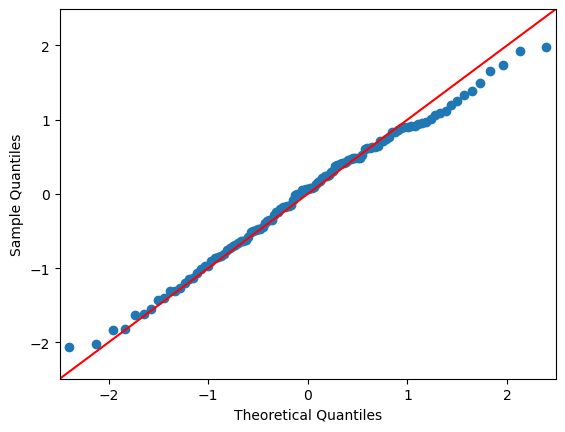

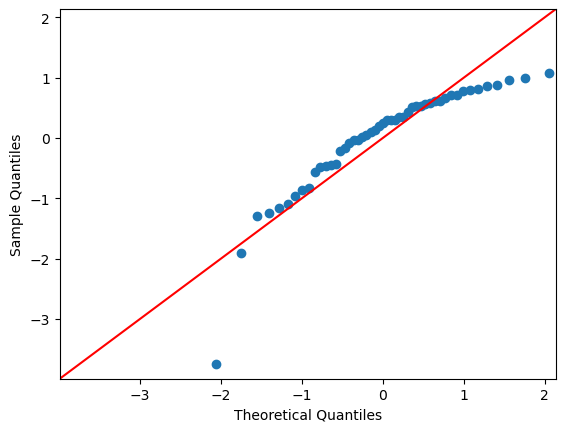

In [72]:
bivariate_regressions = []
for dependent_variable in dependent_variables:
    reg = pooled_ols_reg(regression_df, dependent_variable, [energy_variable])
    bivariate_regressions.append(reg)
    print(reg.summary())
    qqplt = sm.qqplot(data=reg.resid, line='45')

### Single provisioning factors regressions

$$
  \widetilde{NS}_i = a + b_1 \widetilde{ENU}_i + b_2 \widetilde{PF}_i  + b_3 \widetilde{ENU}_i * \widetilde{PF}_i + e_i
$$

In [55]:
pooled_ols_reg(regression_df, 'hale', ['energy', 'material', 'goveffectiveness', 'gini' ,'other'])

### Multiple provisioning factors regressions

$$
  \widetilde{NS}_i = \hat{a} + \hat{b_1} \widetilde{ENU}_i + \hat{b_2} \widetilde{PF}_{1,i}  + \hat{b_3} \widetilde{PF}_{2,i} + \hat{b_4} \widetilde{PF}_{3,i}  + e_i
$$

Conduct a Pooled OLS regression with the following variables:
 - Dependent variable: HALE
 - Independent variables: Energy, Material, Government Effectiveness, Gini, Other

Conduct the same regression on the dataset with and without outliers

First use healthy life expectancy (hale) as the dependent variable

In [56]:
pooled_ols_reg(regression_df, 'hale', ['energy', 'material', 'goveffectiveness', 'gini' ,'other'])

In [57]:
hale_results = pooled_ols_reg(regression_df_no_outliers, 'hale', ['energy', 'material', 'goveffectiveness', 'gini' ,'other'])

In [58]:
print('Mean value of residual errors='+str(hale_results.resid.mean()))

Mean value of residual errors=-2.3853306568679107e-16


Mean value of residual errors is close to zero, which is expected.

/var/folders/6l/9wnlb_cx2h382r0y3jq99h5h0000gn/T/ipykernel_50462/3272153788.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



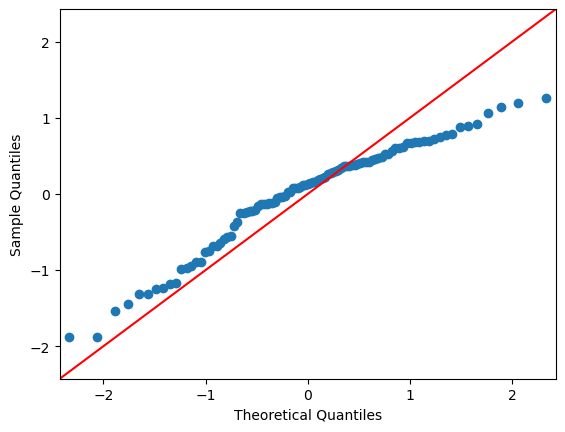

In [59]:
qqplt = sm.qqplot(data=hale_results.resid, line='45')
qqplt.show()

Result for the dataset without outliers: R-squared = 0.523 (with outliers 0.509)
Material has a positive coefficient 0.53 with p-value >0.000 (for every unit increase in material share, HALE increases by 0.53 years)
Other has a negative coefficient -0.226 with p-value 0.014 (for every unit increase in other share, HALE decreases by 0.226 years)

Next use education as the dependent variable

In [60]:
pooled_ols_reg(regression_df_no_outliers, 'education', ['energy',  'goveffectiveness','providential'])

Result for the dataset without outliers: R-squared = 0.347. 
Somewhat low, needs more work. Could be due to a lower sample size (46 observations).
Might be early to interpret the results.

Next: conduct further checks for heteroskedasticity, etc.

## Regression by sector (Later)
 - Use sectoral energy input (per cap? share?), sectoral labor share and sector-related need satisfaction variable

## Regression by region (Later)
 - Use total regional energy input (per cap? share?), total regional labor share and total regional need satisfaction variable

**Note**: We're not doing a fourth set of 
regressions by region + input due to data availability. Maybe in future research